In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Input, concatenate, LSTM, Dropout
from keras.models import model_from_json, Model
from keras.callbacks import EarlyStopping

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np

# Prepare Data

In [4]:
df = pd.read_csv("../data/main_USDJPY_1M.csv")
df.head()

,Unnamed: 0,VxC,vwap20
0,0,6476.89987,111.038814
1,1,4870.37565,111.040495
2,2,2207.13973,111.044022
3,3,2688.49900,111.046828
4,4,4318.18491,111.049688


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


,Close,vwap20
0,111.077,111.038814
1,111.069,111.040495
2,111.079,111.044022
3,111.095,111.046828
4,111.093,111.049688


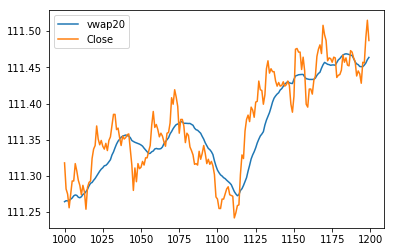

In [8]:
df = df.loc[:,['Close', 'vwap20']]
df[1000:1200].plot(y = ['vwap20', 'Close'])
df.head()

In [10]:
scaler = MinMaxScaler(feature_range = (0,1))
df = scaler.fit_transform(df)
time_lags = 10
n_outputs = 5
n_samples = df.shape[0] - time_lags - n_outputs + 1
X = np.zeros((n_samples, time_lags, df.shape[1]))
Y = np.zeros((n_samples, n_outputs))

for sample in range(n_samples):
    pred_index = sample+time_lags
    X[sample,:, :] = df[sample:pred_index, :]
    Y[sample,:] = df[pred_index:pred_index+n_outputs,0]  

In [13]:
batch_size = 32
upper_limit = X.shape[0] - (X.shape[0] % batch_size)
X = X[:upper_limit]
Y = Y[:upper_limit]

test_percentage = 0.4
test_limit = int(X.shape[0] * test_percentage - X.shape[0] * test_percentage % batch_size)

X_train = X[:test_limit]
X_test = X[test_limit:]
Y_train = Y[:test_limit]
Y_test = Y[test_limit:]
Y_train.shape

(426656, 5)

# Build Model

In [14]:
n_nodes_1 = 60
n_nodes_2 = 20
epochs = 10

lowest_mse = 1000
#for n_nodes_1 in range(50,110,50):
 #   for n_nodes_2 in range(10,100,30):
model = Sequential()
model.add(LSTM(n_nodes_1, activation='tanh', dropout = 0.1, recurrent_dropout = 0.1, 
               return_sequences = True, stateful = True, batch_input_shape = (batch_size, time_lags, X.shape[2])))
model.add(LSTM(n_nodes_2, activation='tanh', dropout = 0.1, recurrent_dropout = 0.1, return_sequences = False, stateful = True))

model.add(Dense(Y_train.shape[1]))
model.compile(loss='mean_squared_error', metrics = ['acc'], optimizer='adam')
history = model.fit(
                X_train, 
                Y_train, 
                epochs = epochs, 
                batch_size = batch_size, 
                verbose = 2,
                validation_data = (X_test, Y_test),
                shuffle = False)
if(min(history.history['val_loss']) < lowest_mse):
    lowet_mse = min(history.history['val_loss'])
    best_model = model

#print(n_1)
#print(n_2)
#print(min(history.history['val_loss']))
#print()

        



Train on 426656 samples, validate on 640000 samples
Epoch 1/10
 - 348s - loss: 6.6693e-04 - acc: 0.1924 - val_loss: 0.0455 - val_acc: 0.2014
Epoch 2/10
 - 389s - loss: 3.7600e-04 - acc: 0.1966 - val_loss: 0.0447 - val_acc: 0.1963
Epoch 3/10
 - 306s - loss: 4.0056e-04 - acc: 0.2089 - val_loss: 0.0423 - val_acc: 0.2107
Epoch 4/10
 - 316s - loss: 4.1307e-04 - acc: 0.2100 - val_loss: 0.0420 - val_acc: 0.2861
Epoch 5/10
 - 323s - loss: 4.1036e-04 - acc: 0.1950 - val_loss: 0.0415 - val_acc: 0.2285
Epoch 6/10
 - 317s - loss: 3.9695e-04 - acc: 0.1893 - val_loss: 0.0387 - val_acc: 0.1721
Epoch 7/10
 - 309s - loss: 3.7342e-04 - acc: 0.1837 - val_loss: 0.0375 - val_acc: 0.2013
Epoch 8/10
 - 306s - loss: 3.6607e-04 - acc: 0.1888 - val_loss: 0.0379 - val_acc: 0.2217
Epoch 9/10
 - 322s - loss: 3.5641e-04 - acc: 0.1889 - val_loss: 0.0338 - val_acc: 0.1995
Epoch 10/10
 - 290s - loss: 3.3789e-04 - acc: 0.1943 - val_loss: 0.0302 - val_acc: 0.2313


In [15]:
predictions = model.predict(X_test)

IndexError: index 24 is out of bounds for axis 1 with size 10

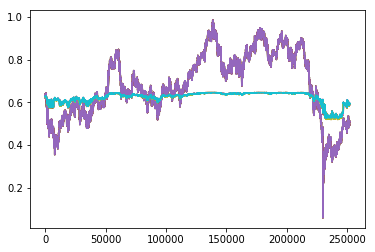

In [16]:
x_low = 0
x_high = 252000
plt.plot(Y_test[x_low:x_high])
plt.plot(predictions[x_low:x_high])
plt.plot(X_test[x_low:x_high,24,1])
plt.plot()
plt.show()

In [247]:
predictions.shape

(6233, 1)

In [69]:
predictions +=0.04

In [17]:
count = 0
count_wrong = 0
long = 0
short = 0
time_step = 4
for i in range(1,Y_test.shape[0]):
    if(Y_test[i,time_step] < Y_test[i-1,time_step] and predictions[i,time_step] < Y_test[i-1,time_step]):
        count = count + 1
        short +=1
    elif(Y_test[i,time_step] > Y_test[i-1,time_step] and predictions[i,time_step] > Y_test[i-1,time_step]):
        count = count + 1
        long +=1
    else:
        count_wrong = count_wrong + 1

correct_perc = count / (Y_test.shape[0] - 1)
print(correct_perc)

        

0.4528897701402658


In [55]:
long_pred = 0
short_pred = 0
same_pred = 0
for i in range(1,Y_test.shape[0]):
    if(predictions[i,0] < Y_test[i-1,0]):
        short_pred+=1
    elif(predictions[i,0] > Y_test[i-1,0]):
        long_pred+=1
    else:
        same+=1
print('short: {}'.format(short_pred))
print('long: {}'.format(long_pred))
print('same: {}'.format(same_pred))

54610/95997

short: 158733
long: 54610
same: 0


0.568871943914914

In [50]:
long = 0
short = 0
for i in range(1,Y_test.shape[0]):
    if(Y_test[i,0] > Y_test[i-1,0]):
        long += 1
    elif(Y_test[i,0] < Y_test[i-1,0]):
        short += 1

long_train = 0
short_train = 0
for i in range(1,Y_train.shape[0]):
    if(Y_train[i,0] > Y_train[i-1,0]):
        long_train += 1
    elif(Y_train[i,0] < Y_train[i-1,0]):
        short_train += 1
print(short)
print(long)

print(short_train)
print(long_train)

95951
95997
394312
392749


In [63]:
X_test.shape

(213344, 25, 2)

In [31]:
df = pd.read_csv("test.csv", names = ['date','open','high', 'low', 'close', 'volume'], sep = ';')


# Save Dataframe

In [ ]:
df.to_csv('test.csv', index = False)

In [ ]:
df = pd.read_csv("test.csv")
df.head()
